<a href="https://colab.research.google.com/github/condusinew/vaccine_failure_escape/blob/main/SIR_simplest_timing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Like SIR_simplest but the infected timing can vary

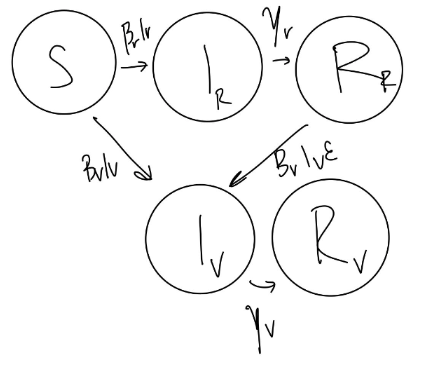

$\frac{\mathrm{d}S}{\mathrm{d}t} = -(\beta_r I_r + \beta_v I_v)S$

$\frac{\mathrm{d}I_r}{\mathrm{d}t} = \beta_r I_r S - \gamma_r I_r$

$\frac{\mathrm{d}R_r}{\mathrm{d}t} = \gamma_rI_r - \beta_v I_v \epsilon R_r$

$\frac{\mathrm{d}I_v}{\mathrm{d}t} = \beta_r I_r S + \beta_v I_v \epsilon R_r - \gamma_v I_v$

$\frac{\mathrm{d}I_v}{\mathrm{d}t} = \gamma_v I_v$

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


In [2]:
# SIR model equations
def SIR_model_rv(t, y, epsilon, betar, gammar, betav, gammav):
    S, Ir, Rr, Iv, Rv = y
    dSdt = -(betar*Ir + betav*Iv) * S
    dIrdt = betar * Ir * S - gammar * Ir
    dRrdt = gammar * Ir - betav*Iv*epsilon*Rr
    dIvdt = betav*Iv*S + betav*Iv*epsilon*Rr - gammav * Iv
    dRvdt = gammav * Iv
    return [dSdt, dIrdt, dRrdt, dIvdt, dRvdt]

In [32]:
# set parameter values
Rrnaught = 5
gammar = 1/10
betar = Rrnaught * gammar

Rvnaught = 5
gammav = 1/14
betav = Rvnaught * gammav

epsilon = 0.3
tmax = 200

# set initial conditions
S0 = 0.99
Ir0 = 0.01
Rr0 = 0

Rv0 = 0
Iv0 = 1 - (S0+Ir0+Rr0+Rv0)

if Iv0 < 0:
  raise ValueError('Check initial params sum to 1')


y0 = [S0, Ir0, Rr0, Iv0, Rv0]





In [33]:
# find time of variant arising

# run sir model (with no variant) until R = 0.1
def _reach_size10(t, y, epsilon, betar, gammar, betav, gammav):
    return y[2] - 0.1

_reach_size10.terminate = True

# RUN BEFORE SEEDING
# RUN WHEN Iv = 0
sol_findtv = solve_ivp(SIR_model_rv, [0,tmax], y0,
                 args=(epsilon, betar, gammar, betav, gammav),
                 events=_reach_size10, t_eval = np.linspace(0, tmax, 1000)) #changed dense output to np.linspace

# get tv and seed Iv
tv = np.ravel(np.array(sol_findtv.t_events))[0]



In [34]:

sol1 = solve_ivp(SIR_model_rv, [0,tv], y0,
                 args=(epsilon, betar, gammar, betav, gammav),
                 events=_reach_size10, t_eval = np.linspace(0, tv, 1000))



In [35]:
y_tv = sol1.y[:, -1]

y_tv[2] -= 0.001   # seed small fraction into Iv
y_tv[3] = 0.001


In [36]:
sol2 = solve_ivp(
    SIR_model_rv,
    [tv, tmax],     # start at tv
    y_tv,           # use updated initial condition
    args=(epsilon, betar, gammar, betav, gammav),
    t_eval = np.linspace(tv, tmax, 1000)
)



In [37]:
t_full = np.concatenate([sol1.t, sol2.t])
y_full = np.hstack([sol1.y, sol2.y])
S, Ir, Rr, Iv, Rv = y_full


ODEINT VS SOLVE IVP


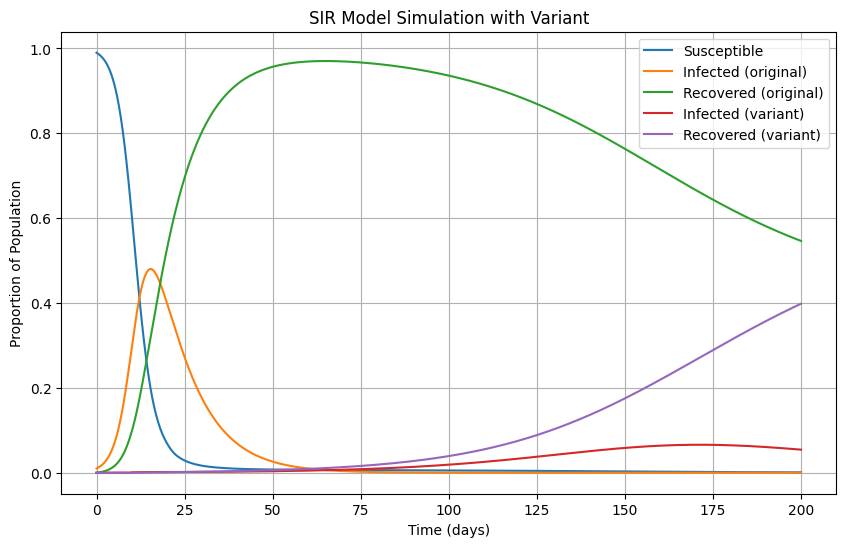

In [38]:
# Extract time and solution arrays
t = t_full
S, Ir, Rr, Iv, Rv = y_full

plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Susceptible')
plt.plot(t, Ir, label='Infected (original)')
plt.plot(t, Rr, label='Recovered (original)')
plt.plot(t, Iv, label='Infected (variant)')
plt.plot(t, Rv, label='Recovered (variant)')

plt.xlabel('Time (days)')
plt.ylabel('Proportion of Population')
plt.title('SIR Model Simulation with Variant')
plt.legend()
plt.grid(True)
plt.show()
